In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ref for simran 
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# ref for Srikar 
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
# ref for Xiangchen
%cd 143 projects

/content/drive/MyDrive/143 projects


In [2]:
# ref for Steven
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
# ref for Yuchao
%cd drive/MyDrive

/content/drive/MyDrive


# <center>**IBM Employee Attrition Analysis**<center>
#### <center>**ECE143 Project, Group 17**</center>
#### <center>**Importance of the Project**</center>
Attrition or loss of employees is an inevitable part of any business. If not handled properly, companies can lose well-trained and experienced employees causing major economical loss. 
Our objective is to find factors that may cause a high employee attrition in order to help companies to intervene on time and remedy the situation.

## 1. Understanding the dataset

**Properties of Dataset**
* Link: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset
*  This dataset records over 1500 employees’ work information including their age, gender, monthly income and whether they have left the company. 

**Step 1: Let's include the packages we need to analyze the dataset**





In [4]:
import io
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

**Step 2: Let's gather the basic information about the dataset**
Let's look at the columns' details, and a few entries of the dataset. Let's segregate the columns into the following:
* Key column: Attrition (Yes/No)
* Numerical columns: Age, Monthly Income, Distance from home, etc.
* Categorical columns: Overtime, Job Level, Employee Satisfaction, etc.

In [5]:
raw_df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
raw_df.info()
raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## 2. Preprossing
### 2.1 Dataset Cleaning
In the raw dataset, each row includes all information of one employee. There are 35 columns for employee information, but four of them make no sense. "EmplyeeNumber" represents IDs, so its values are unique for each person, while the other three meaningless columns hold same values for all employees. Therefore, these four columns should be dropped.

In [6]:
def preprocess(raw_df):
  orig_df = raw_df.drop(columns=["EmployeeNumber","EmployeeCount", "Over18", "StandardHours"])
  df = orig_df.replace({
    "Attrition": {
        'Yes':1,
        'No': 0
        },
    "BusinessTravel": {
        "Non-Travel":0,
        "Travel_Rarely":1,
        "Travel_Frequently":2
    },
    "Overtime": {
        'Yes':1,
        'No':0
    },
    'Education': {
        1 : "Below College",
        2 : "College",
        3 : "Bachelors", 
        4 : "Masters", 
        5 : "PhD"
    },
    "JobInvolvement": {
        1 : "Low",
        2 : "Medium",
        3 : "High",
        4 : "Very High"
    },
    "JobSatisfaction": {
        1 : "Low",
        2 : "Medium",
        3 : "High",
        4 : "Very High"
    },
    "PerformanceRating": {
        1 : "Low",
        2 : "Medium",
        3 : "High",
        4 : "Very High"
    }
  })
  df.head(3)
  return df


df = preprocess(raw_df)

After preprocessing, we also classify the remaining columns into three groups as mentioned in the previous part: 
- Key columns: "Attrition"   
- Numerical columns: values in a continuous numerical range, like "Age", "DailyRate", etc.   
- Categorical columns: values in a discrete range, like "Department", "JobStisfaction", etc.   


### 2.2 Correlation matrix
This is the heat map based on the correlation matrix among columns. We use this matrix to do a pre-analysis, avoiding some unnecessary work. The correlation indices in the matrix are in the range [-1, 1]. When index is close to 1, it means a strong positive correlation; conversely, a negative index represent negative correlation; 0 means no correlation.

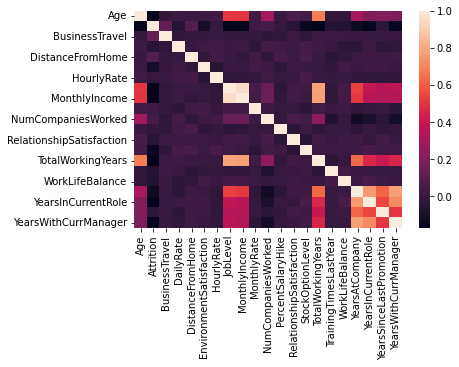

In [7]:
df_norm = (df-df.mean())/df.std()
sns.heatmap(df_norm.corr())


According to the heat map, the last 4 features(columns) related to working years are highly correlated, thus comparasions on them are insignificant. Moreover, monthly income, hour rate and job level are also in relatively high positivity, which is in common sense.    

**Therefore, this correlation matrix gives us directions on which features we should focus on for analysis.**

## 3. Numerical Analysis
### 3.1 A simple start on monthly income

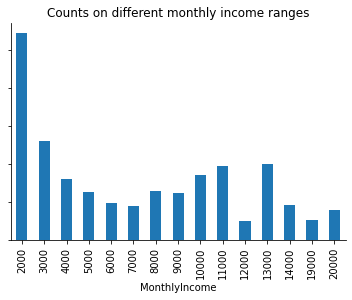

In [8]:
# normalize monthly income and plot the relation between monthly income to attrition rate
def normalize_x(x):
  '''
  normalize monthly income in to groups
  '''
  assert isinstance(x, int)
  assert x >= 0

  import math
  return math.ceil(x/1000)*1000

df['MonthlyIncome'] = df['MonthlyIncome'].apply(normalize_x)
ax_income = df.groupby('MonthlyIncome')['Attrition'].value_counts(normalize=True)[:, 1].plot(kind='bar')
ax_income.set(yticklabels=[], title='Counts on different monthly income ranges')
ax_income.spines['right'].set_visible(False)
ax_income.spines['top'].set_visible(False)

### 3.2 Data Distribution

In [9]:
def plot_line_remove_ytick(col:str):
  '''
  plot continuous histogram on numerical features comparing attrited group and remained group
  '''
  ax = sns.kdeplot(x = df.loc[df.Attrition == 0][col], label = "Still Employed", color = "steelblue")
  ax = sns.kdeplot(x = df.loc[df.Attrition == 1][col], label = "Left Company", color = "red")
  min_val=min(df[col])
  max_val=max(df[col])
  ax.set_title('{} comparison among two groups'.format(col))
  ax.set_xlabel(col)
  ax.set_xlim(min_val,max_val)
  ax.set(yticklabels=[])
  ax.legend()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  return ax

####3.2.1 How distribution changes between attrited and still working employees with age.

Firstly, Let’s look at the numerical features and their relation with attrition. We selected age, monthly income and work distance in our presentation. As expected, we can see employees that are younger than 33 are more likely to leave the company.

Younger employees are more likely to leave the company!


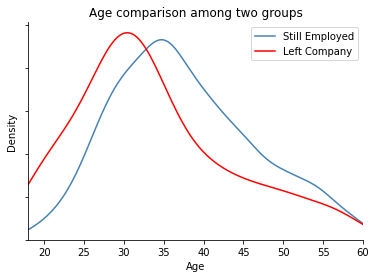

In [10]:
plot_line_remove_ytick('Age')

####3.2.2 How distribution changes between attrited and still working employees with monthly income.

Similarly the analysis between monthly income and attrition shows a negative correlation between the two. A higher number of employees leave the company if they have have incomes below 4000$..

Employees with relatively low monthly income are more likely to leave the company.

This is very intuitive!


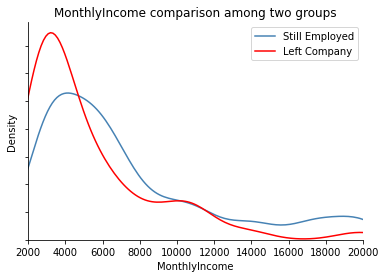

In [11]:
plot_line_remove_ytick('MonthlyIncome')

####3.2.3 How distribution changes between attrited and still working employees with distance from home.

For distance from work, and we can see the correlation is positive. Long distance from home more than 10 miles indeed results in higher attrition rates. All those factors and their relationship with attrition rate are consistent with our intuition as well as our hypothesis.


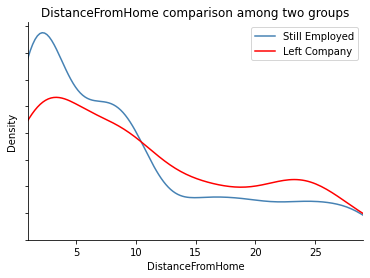

In [12]:
plot_line_remove_ytick('DistanceFromHome')

####3.2.4 How distribution changes between attrited and still working employees with total working years.


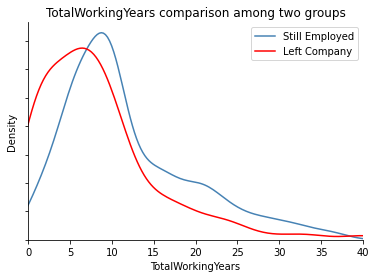

In [13]:
plot_line_remove_ytick('TotalWorkingYears')

### 3.3 Combined Analysis - linear regression
Here we combine the monthly income and total working years to analyze their influences on attrition.

####3.3.1 How monthly income varies with age among attrited and still working employees. 


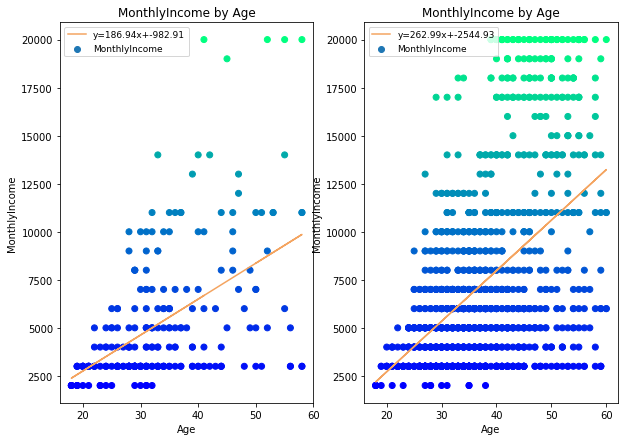

In [14]:
  # The question is how salary rise do we need to stay in the company as age increases
  # First we divide the dataframe into those who attrited from the company and those who do not.
  # Then we plot their age vs their monthly income and compute the regression line for these two groups and compare their difference

  fig, ax = plt.subplots(figsize=(10,7), nrows=1, ncols=2)
  df_attrited = df.loc[df['Attrition'] == 1]
  df_remained = df.loc[df['Attrition'] == 0]

  ax[0].scatter(data=df_attrited, x='Age', y='MonthlyIncome', c='MonthlyIncome', cmap='winter')
  ax[0].set(title='MonthlyIncome by Age', xlabel='Age', ylabel='MonthlyIncome')
  ax[1].scatter(data=df_remained, x='Age', y='MonthlyIncome', c='MonthlyIncome', cmap='winter')
  ax[1].set(title='MonthlyIncome by Age', xlabel='Age', ylabel='MonthlyIncome')

  m, b = np.polyfit(df_attrited.Age, df_attrited.MonthlyIncome, 1)
  ax[0].plot(df_attrited.Age, m * df_attrited.Age + b, c='sandybrown', label='y={:.2f}x+{:.2f}'.format(m,b))
  ax[0].legend(fontsize=9, loc='upper left')

  m, b = np.polyfit(df_remained.Age, df_remained.MonthlyIncome, 1)
  ax[1].plot(df_remained.Age, m * df_remained.Age + b, c='sandybrown', label='y={:.2f}x+{:.2f}'.format(m,b))
  ax[1].legend(fontsize=9, loc='upper left')

  plt.show()

####3.3.2 How monthly income varies with working years among attrited and still working employees. 

We are also curious about the combination between income and employees’ total working years. From this graph we can see that  the slope of the regression line for those who remain in the company is higher than those who left, which means company should be generous to pay the experienced employees in order to keep them in the company. Specifically, company should raise the monthly salary at least 479 dollars per working year for a employee.


377.7986645164611
478.442787467828


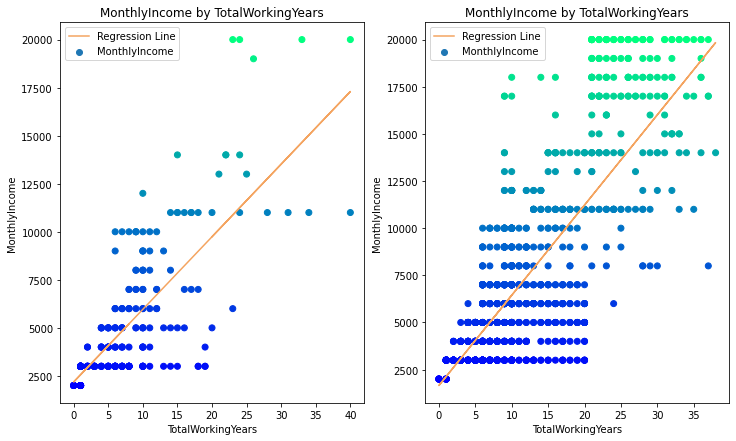

In [15]:
# The question is how salary rise do we need to stay in the company as age increases
# First we divide the dataframe into those who attrited from the company and those who do not.
# Then we plot their age vs their monthly income and compute the regression line for these two groups and compare their difference

fig, ax = plt.subplots(figsize=(12,7), nrows=1, ncols=2)
df_attrited = df.loc[df['Attrition'] == 1]
df_remained = df.loc[df['Attrition'] == 0]

ax[0].scatter(data=df_attrited, x='TotalWorkingYears', y='MonthlyIncome', c='MonthlyIncome', cmap='winter')
ax[0].set(title='MonthlyIncome by TotalWorkingYears', xlabel='TotalWorkingYears', ylabel='MonthlyIncome')
ax[1].scatter(data=df_remained, x='TotalWorkingYears', y='MonthlyIncome', c='MonthlyIncome', cmap='winter')
ax[1].set(title='MonthlyIncome by TotalWorkingYears', xlabel='TotalWorkingYears', ylabel='MonthlyIncome')

m, b = np.polyfit(df_attrited.TotalWorkingYears, df_attrited.MonthlyIncome, 1)
print(m)
ax[0].plot(df_attrited.TotalWorkingYears, m * df_attrited.TotalWorkingYears + b, c='sandybrown', label='Regression Line')
ax[0].legend(fontsize=10, loc='upper left')

m, b = np.polyfit(df_remained.TotalWorkingYears, df_remained.MonthlyIncome, 1)
print(m)
ax[1].plot(df_remained.TotalWorkingYears, m * df_remained.TotalWorkingYears + b, c='sandybrown', label='Regression Line')
ax[1].legend(fontsize=10, loc='upper left')

plt.show()

### 3.4 Two sample T-tests

A two sample t-test is used to test whether the means of two populations are the same.

* Significance Level: 0.05


* Null Hypothesis:  Age(Monthly Income/Distance) has SAME means among two groups (two-sides)


* Alternative Hypothesis: Age(Monthly Income/Distance) has the DIFFERENT means among two groups

The previous graphs spoke to us intuitively. However, consistency with intuition is not enough. We want to use statistical testing to validate our findings. Therefore we set up two sample t test to test the if factor’s mean are different among two groups. In order to validate what we have visualized, we want to reject the null hypothesis.



In [24]:
# create a new col 'growth'
df['growth']=df['MonthlyIncome']/df['TotalWorkingYears']
df['growth']=df['growth'].apply(lambda x: 0 if x>1000 else x)

In [25]:
# read csv and seperate into two categories according to attrition
# First select all numerical cols
df_attrited=df.loc[df['Attrition']==1].reset_index(drop=True)
df_remain=df.loc[df['Attrition']==0].reset_index(drop=True)

num_col=df.select_dtypes('number').columns.to_list()
cat_col=df.select_dtypes(object).columns.to_list()
num_col.remove('Attrition')

df_attrited=df_attrited[num_col]
df_remain=df_remain[num_col]

In [26]:
# two sample t tests for each numerical columns
# select those with p value less than 0.05
p_vals={}

for i in num_col:
    mean_attrited=np.mean(df_attrited[i])
    mean_remain=np.mean(df_remain[i])
    ttest,pval = stats.ttest_ind(df_attrited[i],df_remain[i])
    p_vals[i]=round(pval,3)

df_pval=pd.DataFrame(p_vals,index=['p_value']).T
df_pval_reject=df_pval.loc[df_pval['p_value']<=0.05].T

In [27]:
df_pval_reject.T.sort_values(ascending=True,by='p_value')

,p_value
Age,0.000
BusinessTravel,0.000
EnvironmentSatisfaction,0.000
JobLevel,0.000
MonthlyIncome,0.000
StockOptionLevel,0.000
TotalWorkingYears,0.000
YearsAtCompany,0.000
YearsInCurrentRole,0.000
YearsWithCurrManager,0.000


Here we have shown the p values of each test. The p-value is the probability of obtaining our observation(that is our data sample) assuming the null hypothesis is true. Therefore we can see that the probability is lower than the significance level, therefore we successfully reject the null hypothesis and validate our findings.


In [28]:
df_new=df_pval_reject[['Age','MonthlyIncome','DistanceFromHome','growth']]
df_new.rename({'growth':'IncomeGrowthPerWorkyear'},axis=1,inplace=True)
df_new.T

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,p_value
Age,0.000
MonthlyIncome,0.000
DistanceFromHome,0.003
IncomeGrowthPerWorkyear,0.000


## 4. Categorical Analysis 
This part will focus on analysis bewteen Attrition and selected categorical columns.

In [ ]:
def plotCategoricalAnalysis(cate_col_name):
  '''
  plot graphs for Categorical Analysis, including pie charts for percentage comparison
  as well as bar charts for counts and percentage comparisons
  '''
  plotSize = (6,4)
  df[cate_col_name].value_counts().plot.pie(figsize=plotSize, title='Percentage of emloyees in '+cate_col_name, autopct='%.2f%%', rot=0)
  attr_cate_data = df[['Attrition', cate_col_name]].value_counts().unstack()
  ax_countBar = attr_cate_data.T.plot.bar(figsize=plotSize, title='Attrition comparison of counts', xlabel='Attrition', ylabel='Counts', rot=0)
  ax_countBar.set(yticklabels=[])
  attr_cate_percent = attr_cate_data.T/attr_cate_data.apply(sum, axis=1)*100
  ax_percentBar = attr_cate_percent.plot.bar(figsize=plotSize, title='Attrition comparison of percentage', xlabel=cate_col_name, ylabel='Attrition Percentage',rot=0)
  ax_percentBar.set(yticklabels=[])

### 4.1 Attrition vs Gender

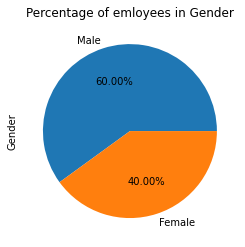

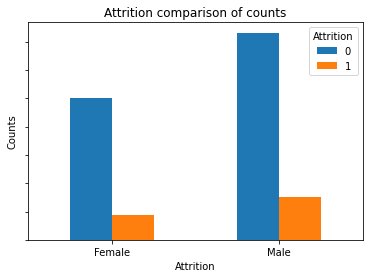

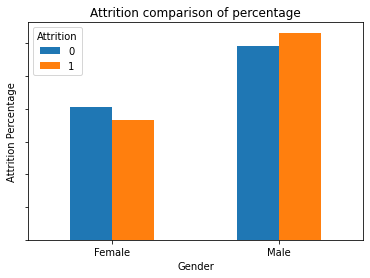

In [ ]:
plotCategoricalAnalysis('Gender')

Comments:   
- The number of the male is slightly larger than the female.
- The counts for attrited vs remained are similar for male and female
- The percentage of attrited female is larged than remained, while conversely for male. The reason might be that, female might pay more attention to family instead of working.

### 4.2 Attrition vs JobSatisfaction

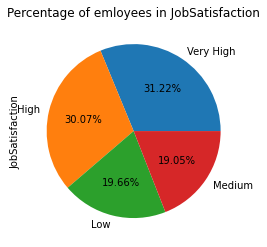

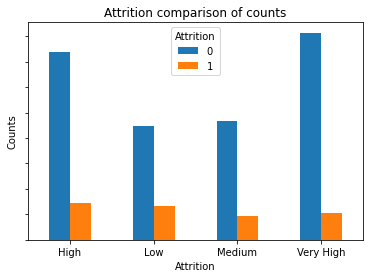

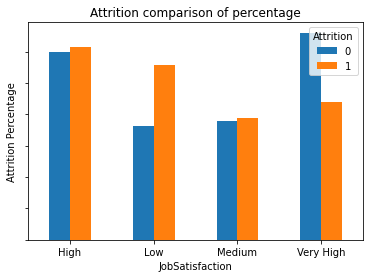

In [ ]:
plotCategoricalAnalysis('JobSatisfaction')

Comments:   
- More than half of employees are satisfied with their jobs
- The counts analysis in this time make no sense, only percentage is meaningful where a normalization is applied
- As the degree of satisfaction increases, the attrited peercentage 

### 4.3 Attrition vs EducationField

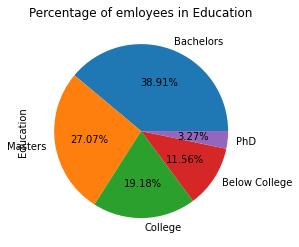

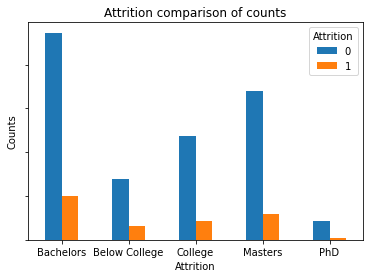

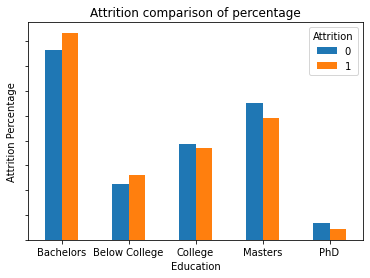

In [ ]:
plotCategoricalAnalysis('Education')

Comments:   
- Most of employees are bachelar and master degrees.
- The counts analysis in this time make no sense, only percentage is meaningful where a normalization is applied
- Higher level of eduction lead to a lower percentage of attrition.
- College eduction, which is for working purposes, also lead to a slightly lower percentage of attrition.

## 5. Deep Analysis
Deep analysis includes mixed analyses on numerical and categorical columns.

###5.1 The relation between gender and job level

We wanted to understand how attrition rate varied across job levels and salary with respect to the two genders in the datasets. The intuition or common knowledge was that female attrition is higher as the job level increases and there is a skewed ratio of employees w.r.t. Gender at higher job levels. However, contrary to what we know, we observe that the attrition rate ratio between males and females is maintained across job levels and we also notice that the pay gap is lesser with this dataset.  


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


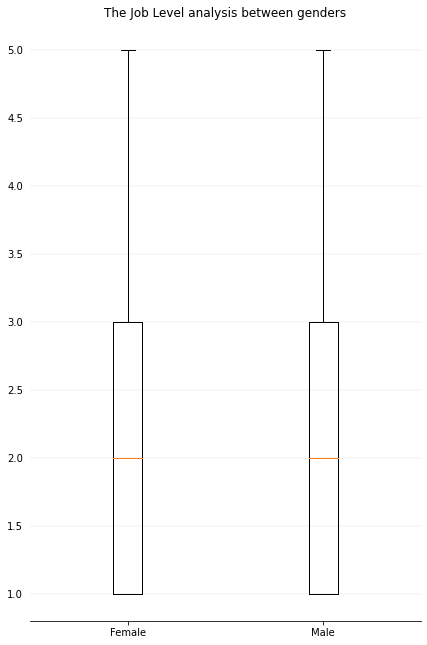

Text(0.5, 0.98, 'These two piecharts below show us the proportion of attrition of each gender in each job level')

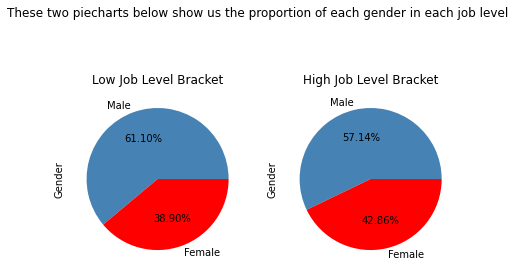

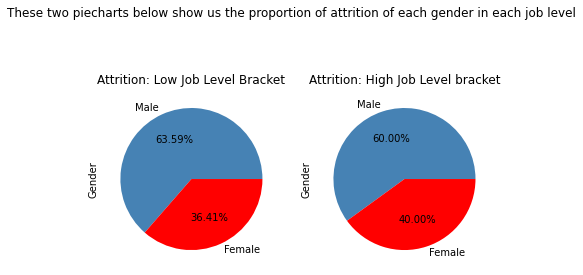

In [ ]:
# Let's make a box plot to understand the 

df = raw_df.filter(['JobLevel','Gender'], axis=1)
male_joblevel = df[df['Gender'] == 'Male']['JobLevel']
female_joblevel = df[df['Gender'] == 'Female']['JobLevel']
fig, ax = plt.subplots(figsize=(7, 11))

# Remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y-axis tick marks
ax.yaxis.set_ticks_position('none')

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

# Set plot title
ax.set_title('The Job Level analysis between genders')
dataset = [female_joblevel, male_joblevel]
labels = df['Gender'].unique()
ax.boxplot(dataset, labels=labels)
plt.show()

higher_df = df[df['JobLevel'] > 3]
smaller_df = df[df['JobLevel'] < 3]

fig, ax = plt.subplots(1,2, figsize = (16,4))
smaller_df['Gender'].value_counts().plot.pie(figsize=(7, 5), colors = ['steelblue','red'], autopct='%.2f%%', rot=0, ax = ax[0], title = "Low Job Level Bracket")
higher_df['Gender'].value_counts().plot.pie(figsize=(7, 5), colors = ['steelblue','red'], autopct='%.2f%%', rot=0, ax = ax[1], title = "High Job Level Bracket")
fig.suptitle("These two piecharts below show us the proportion of each gender in each job level")


# rslt_df['Gender'].value_counts().plot.pie(figsize=(7, 5), colors = ['sandybrown','cornflowerblue'], autopct='%.2f%%', rot=0)
df = raw_df.filter(['JobLevel','Gender','Attrition'], axis=1)
higher_df = df[df['JobLevel'] > 3]
higher_df = higher_df[higher_df['Attrition'] =='Yes']
smaller_df = df[df['JobLevel'] < 3]
smaller_df = smaller_df[smaller_df['Attrition'] =='Yes']

fig, ax = plt.subplots(1,2, figsize = (16,4))
smaller_df['Gender'].value_counts().plot.pie(figsize=(7, 5),
                                             colors = ['steelblue','red'],
                                             autopct='%.2f%%',
                                             rot=0, ax = ax[0],
                                             title = "Attrition: Low Job Level Bracket")

higher_df['Gender'].value_counts().plot.pie(figsize=(7, 5),
                                            colors = ['steelblue','red'],
                                            autopct='%.2f%%',
                                            rot=0, ax = ax[1],
                                            title = "Attrition: High Job Level bracket")

fig.suptitle("These two piecharts below show us the proportion of attrition of each gender in each job level")


###5.2 Analysis of Gender vs Age

The next thing we wanted to analyze was how attrition rate changes w.r.t age and gender of the employee. We observe that irrespective of gender, there’s almost equal attrition in the younger age group of employees. 


Text(0.5, 0.98, 'These two piecharts below show us the proportion of attrition for each age group for females')

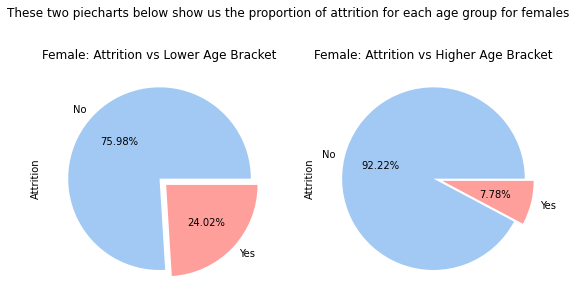

In [ ]:
# updated plots and graphs
# Plot attrition percentages vs Age bracket (>35 or <35) for female employees

df2 = raw_df[['Age', 'Gender', 'Attrition']]
higherAgeBracketFemale = df2[(df2['Age'] >= 35) & (df2['Gender'] == 'Female')]
lowerAgeBracketFemale = df2[(df2['Age'] < 35) & (df2['Gender'] == 'Female')]

explode = (0,0.1)
fig, ax = plt.subplots(1,2, figsize = (16,5))
fhbcolors = [sns.color_palette('pastel')[0], sns.color_palette('pastel')[3]] 
mhbcolors = [sns.color_palette('pastel')[0], sns.color_palette('pastel')[3]] 
higherAgeBracketFemale['Attrition'].value_counts().plot.pie(figsize=(9, 5),
                                                            colors = fhbcolors,
                                                            autopct='%.2f%%',
                                                            rot=0, ax = ax[1],
                                                            title = "Female: Attrition vs Higher Age Bracket",
                                                            explode=explode)

lowerAgeBracketFemale['Attrition'].value_counts().plot.pie(figsize=(9, 5),
                                                           colors = mhbcolors,
                                                           autopct='%.2f%%',
                                                           rot=0, ax = ax[0],
                                                           title = "Female: Attrition vs Lower Age Bracket",
                                                           explode =explode)

fig.suptitle("These two piecharts below show us the proportion of attrition for each age group for females")

It is interesting to see that there is greater attrition in males vs females as the age bracket increases. Female employees with more work experience tend to stay in the company longer

Text(0.5, 0.98, 'These two piecharts below show us the proportion of attrition for each age group for males')

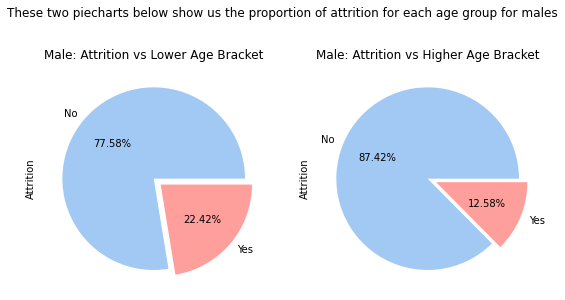

In [ ]:
# Plot attrition percentages vs Age bracket (>35 or <35) for male employees
higherAgeBracketMale = df2[(df2['Age'] >= 35) & (df2['Gender'] == 'Male')]
lowerAgeBracketMale = df2[(df2['Age'] < 35) & (df2['Gender'] == 'Male')]
fig, ax = plt.subplots(1,2, figsize = (16,5))
colors = [sns.color_palette('pastel')[0], sns.color_palette('pastel')[3]] 

higherAgeBracketMale['Attrition'].value_counts().plot.pie(figsize=(9, 5),
                                                          colors = colors,
                                                          autopct='%.2f%%',
                                                          rot=0, ax = ax[1],
                                                          title = "Male: Attrition vs Higher Age Bracket",
                                                          explode=explode)

lowerAgeBracketMale['Attrition'].value_counts().plot.pie(figsize=(9, 5),
                                                         colors = colors,
                                                         autopct='%.2f%%',
                                                         rot=0, ax = ax[0],
                                                         title = "Male: Attrition vs Lower Age Bracket", explode =explode)

fig.suptitle("These two piecharts below show us the proportion of attrition for each age group for males")

###5.3 Overtime vs Attrition

One of the major factors for attrition that we observed is Overtime. We notice that employees who work overtime are three times more likely to leave the company. Implying that work related stress and hours is a major factor for attrition. 


Text(0.5, 0.98, 'These two piecharts below show us the proportion of attrition for each work group (overtime,normal)')

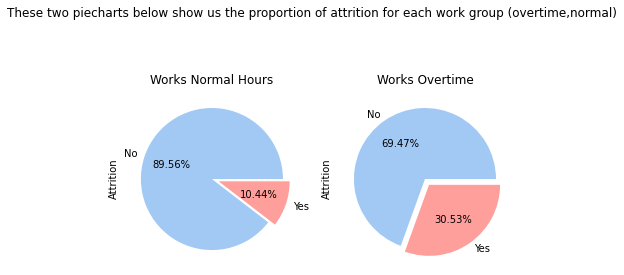

In [ ]:
# Overtime vs Attrition pie charts
df = raw_df.filter(['OverTime','Attrition'], axis=1)
overtime_df = df[df['OverTime'] =='Yes']
normal_df = df[df['OverTime'] == 'No']
fig, ax = plt.subplots(1,2, figsize = (16,5))
colors = [sns.color_palette('pastel')[0], sns.color_palette('pastel')[3]] 
normal_df['Attrition'].value_counts().plot.pie(figsize=(7, 5),
                                               colors = colors,
                                               autopct='%.2f%%',
                                               rot=0, ax = ax[0],
                                               title = "Works Normal Hours",
                                               explode =explode)

overtime_df['Attrition'].value_counts().plot.pie(figsize=(7, 5),
                                                 colors = colors,
                                                 autopct='%.2f%%',
                                                 rot=0, ax = ax[1],
                                                 title = "Works Overtime",
                                                 explode=explode)

fig.suptitle("These two piecharts below show us the proportion of attrition for each work group (overtime,normal)")



### 5.4 How far does personal relationship affect attrition

We wanted to dive deep and understand if employees in different personal relationships would react differently to overtime. We have 3 categories of employees - single, married and divorced. We see that irrespective of personal relationships, if we make an employee work over time that employee is 3 times more likely to leave the company. This shows that while personal life might affect attrition the working environment stress is a crucial part.


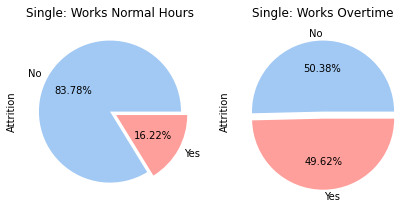

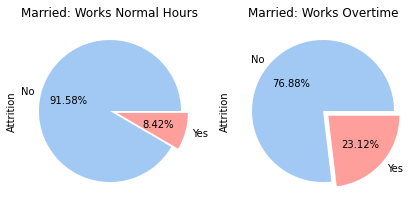

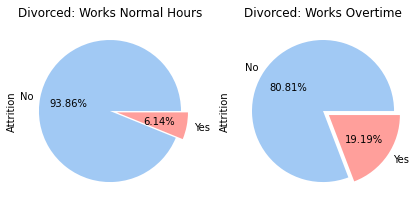

In [ ]:
# Overtime across Marital status vs Attrition pie charts
explode = (0,0.1)
colors = [sns.color_palette('pastel')[0], sns.color_palette('pastel')[3]]
# get the columns to evaluate
df = raw_df.filter(['OverTime','Attrition','MaritalStatus'], axis=1)

# plot pie charts for each of the marital status categories
for status in ["Single","Married","Divorced"]:
  temp_df = df[df["MaritalStatus"]==status]
  overtime_df = temp_df[temp_df['OverTime'] =='Yes']
  normal_df = temp_df[temp_df['OverTime'] == 'No']
  fig, ax = plt.subplots(1,2, figsize = (16,4))
  
  # plot attrition vs marital status for employees working normal hours
  normal_df['Attrition'].value_counts().plot.pie(figsize=(7, 5),
                                                 colors = colors,
                                                 autopct='%.2f%%',
                                                 rot=0, ax = ax[0],
                                                 title = status+": Works Normal Hours",
                                                 explode=explode)
  
  # plot attrition vs marital status for employees working overtime
  overtime_df['Attrition'].value_counts().plot.pie(figsize=(7, 5),
                                                   colors = colors,
                                                   autopct='%.2f%%',
                                                   rot=0, ax = ax[1],
                                                   title = status+": Works Overtime",
                                                   explode=explode)

### 5.5 Are there any other factors that affect attrition?
  

####5.5.1 Job Level vs Attrition
Experimental Analysis on job level vs attrition for male and female employees. We wondered if there would be an observable variation in the attrition in lower job levels. We further wanted to understand if employees if a particular gender showed variable attrition as the job level changed. From the results, we could not draw any meaningful conclusions.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


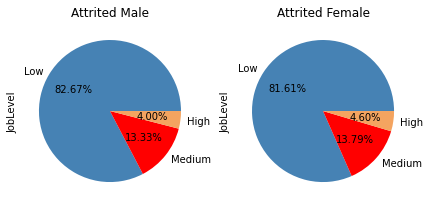

In [ ]:
# Plot job level percentage to those who attrited in male and female group

maleAttrited = orig_df[(orig_df['Attrition'] == 'Yes') & (orig_df['Gender'] == 'Male')]
femaleAttrited = orig_df[(orig_df['Attrition'] == 'Yes') & (orig_df['Gender'] == 'Female')]

def jobLevelNormalize(level):
  '''
  group job level
  '''
  assert isinstance(level, int) and 1 <= level <= 5
  if level <= 2:
    return 'Low'
  elif level >=4:
    return 'High'
  else:
    return "Medium"

maleAttrited['JobLevel'] = maleAttrited['JobLevel'].apply(jobLevelNormalize)
femaleAttrited['JobLevel'] = femaleAttrited['JobLevel'].apply(jobLevelNormalize)

fig, ax = plt.subplots(1,2, figsize = (16,5))
maleAttrited['JobLevel'].value_counts().plot.pie(figsize=(7, 5),
                                                 colors = ['steelblue', 'red', 'sandybrown'],
                                                 autopct='%.2f%%',
                                                 rot=0, ax = ax[0],
                                                 title = "Attrited Male")
femaleAttrited['JobLevel'].value_counts().plot.pie(figsize=(7, 5),
                                                   colors = ['steelblue', 'red', 'sandybrown'],
                                                   autopct='%.2f%%',
                                                   rot=0, ax = ax[1],
                                                   title = "Attrited Female")

####5.5.2 Income level vs Attrition
Experimental Analysis on income level of the employees that left the company. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


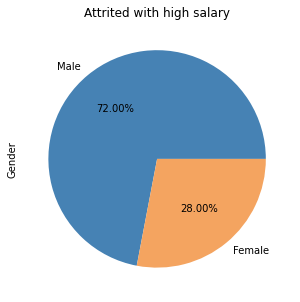

In [ ]:
attrited = orig_df[orig_df['Attrition'] == 'Yes']

def incomeNormalize(income):
  assert isinstance(income, int)

  if income <= 10000:
    return 'Low'
  else:
    return "High"

attrited['MonthlyIncome'] = attrited['MonthlyIncome'].apply(incomeNormalize)
highIncome_df = attrited[attrited['MonthlyIncome'] == 'High']

highIncome_df['Gender'].value_counts().plot.pie(figsize=(7, 5),
                                                colors = ['steelblue', 'sandybrown'],
                                                autopct='%.2f%%',
                                                rot=0,
                                                title = "Attrited with high salary")

####5.5.3 Income level vs Attrition and does gender affect Attrition?
We repeat this experiment with a slightly finer income levels for male and female employees to identify any noticeable pattern. This was also done to normalize the number of employees in the male and female categories.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


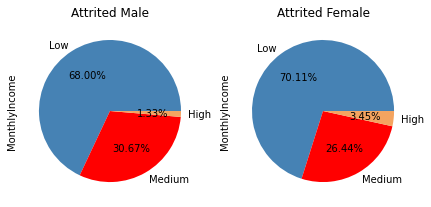

In [ ]:
maleAttrited = orig_df[(orig_df['Attrition'] == 'Yes') & (orig_df['Gender'] == 'Male')]
femaleAttrited = orig_df[(orig_df['Attrition'] == 'Yes') & (orig_df['Gender'] == 'Female')]

def incomeNormalize(income):
  '''
  group income level

  Param:
    income: int

  Return:
    level: str
  '''
  assert isinstance(income, int)

  if income <= 5000:
    return 'Low'
  elif income >= 15000:
    return 'High'
  else:
    return "Medium"

maleAttrited['MonthlyIncome'] = maleAttrited['MonthlyIncome'].apply(incomeNormalize)
femaleAttrited['MonthlyIncome'] = femaleAttrited['MonthlyIncome'].apply(incomeNormalize)

fig, ax = plt.subplots(1,2, figsize = (16,5))
maleAttrited['MonthlyIncome'].value_counts().plot.pie(figsize=(7, 5),
                                                      colors = ['steelblue','red', 'sandybrown'],
                                                      autopct='%.2f%%',
                                                      rot=0, ax = ax[0],
                                                      title = "Attrited Male")

femaleAttrited['MonthlyIncome'].value_counts().plot.pie(figsize=(7, 5),
                                                        colors = ['steelblue', 'red', 'sandybrown'],
                                                        autopct='%.2f%%',
                                                        rot=0, ax = ax[1],
                                                        title = "Attrited Female")

#### 5.5.4 Demographics of employees in different marital statuses
We perform a demographic analysis on marital statuses of employees that left the company to understand if marital status of the employee affects attrition. We repeat this analysis for employees that remained in the company. 

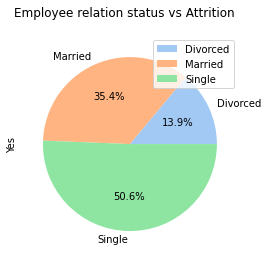

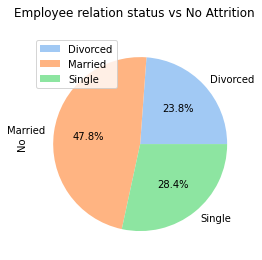

In [ ]:
# marital status vs attrition plot pie chart for marital 

# change back numerical data to categorical data
marital_status_vs_att = orig_df[['MaritalStatus', 'Attrition']]
marital_status_vs_att = marital_status_vs_att.replace({
    "Attrition": {
        0: 'No',
        1: 'Yes'
    }
})
grp = marital_status_vs_att.groupby(by='Attrition')
colors = sns.color_palette('pastel')[0:5]

# group that left the company
grp.get_group('Yes').value_counts().unstack().plot(kind='pie', 
                                               title='Employee relation status vs Attrition',
                                               colors = colors,
                                               subplots=True, 
                                               autopct="%.1f%%")
plt.legend(loc='upper right')

# group that stayed in the company
grp.get_group('No').value_counts().unstack().plot(kind='pie',
                                               title='Employee relation status vs No Attrition',
                                               colors = colors,
                                               subplots=True, 
                                               autopct="%.1f%%")
plt.legend(loc='upper left')

#### 5.5.5 Conclusion on the demographics of marital status of the employees vs attrition

We see that little over 50% of employees that left the company are single employees. Among the employees that stayed in the company, we see that the majority of the population is occupied by employees that are married. This concurs with the general expectation of "settled" employees. 

No major comment can be made on employees who are divorced as the population is sparse to make any generalized statements. 

### 5.6 How does attrition change w.r.t. Department?
Which department sees greater attrition? Does department have any effect on attrition?" These were the questions we wanted to answer and see if we can make any concluding statements towards the data.

There are 3 departments in the dataset

*   Sales
*   Research & Development
*   Human Resources



####5.6.1 'Sales' Employees vs Attrition
We start off with the Sales department and plot the attrition rates within the Sales demographics

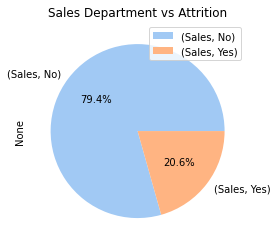

In [ ]:
# department wise attrition plots. 
# Attrition in the Sales Department
department_wise_group = orig_df[['Department', 'Attrition']].value_counts().groupby(by='Department')
colors = sns.color_palette('pastel')[0:5]
department_wise_group.get_group('Sales').plot(kind='pie', 
                                               title='Sales Department vs Attrition',
                                               colors = colors,
                                               autopct="%.1f%%"
                                               )
plt.legend(loc='upper right')


####5.6.2 'Research & Development' vs Attrition

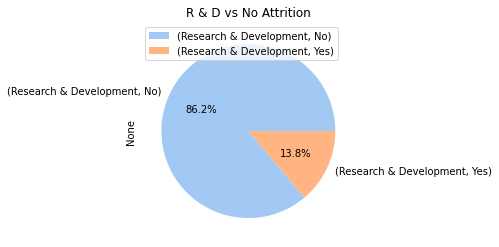

In [ ]:
# Attrition in the Research & Development Department
department_wise_group.get_group('Research & Development').plot(kind='pie',
                                               title='R & D vs No Attrition',
                                               colors = colors,
                                               autopct="%.1f%%")
plt.legend(loc='upper left')

####5.6.3 'Human Resources' vs Attrition

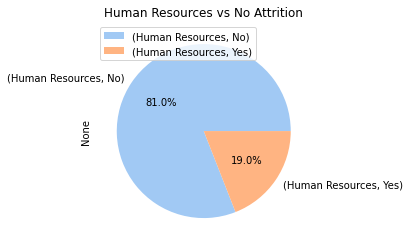

In [ ]:
# Attrition in the Human Resources Department
department_wise_group.get_group('Human Resources').plot(kind='pie',
                                               title='Human Resources vs No Attrition',
                                               colors = colors,
                                               autopct="%.1f%%")
plt.legend(loc='upper left')

#### 5.6.4 Conlusion for Department vs Attrition
As per our expectations, R & D requires long term conviction from the employees and that is reflected in the lower attrition rates in the department. However, in Sales and HR, we see almost 1 in 5 employees who switched from their current company. 

## 6. Further analysis using violin plots
Violin plots are another good method to visualize continuous data distribution according to different classfications. It combined strengthens of box plots and nuclear density plots.

In [ ]:
df = preprocess(raw_df)

def violinPlot(xCol, yCol, subplotCol, subplotVal):
  '''
  plot violin graphs to better visualize relations between numerical and categorical features
  '''
  plt.figure(figsize=(12,6))
  sns.set(color_codes=True)
  subplotData = df.loc[df[subplotCol] == subplotVal][[xCol, yCol]]
  sns.violinplot(x=xCol, y=yCol, data=subplotData, order=np.sort(df[xCol].unique())).set_title(subplotCol +': %s' % subplotVal)
  plt.show()

# Plot sub-analysis of xCol(numerical) vs yCol(categorical) based on the all values of selected classification column (categorical)
def mixedAnalysis(xCol, yCol, subplotCol):
  sortedCol = np.sort(df[subplotCol].unique())
  for val in sortedCol:
    violinPlot(xCol, yCol, subplotCol, val)

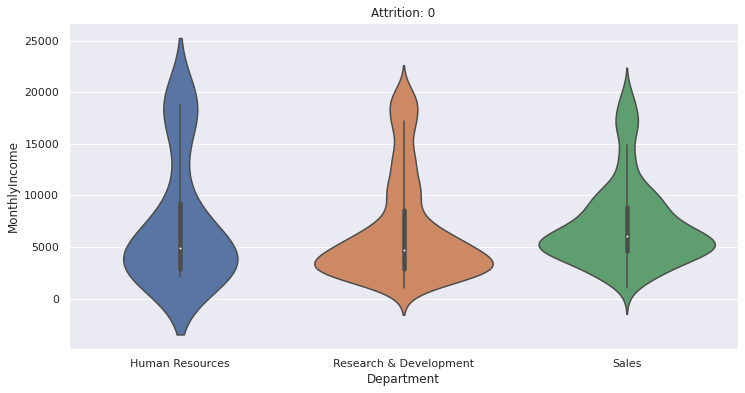

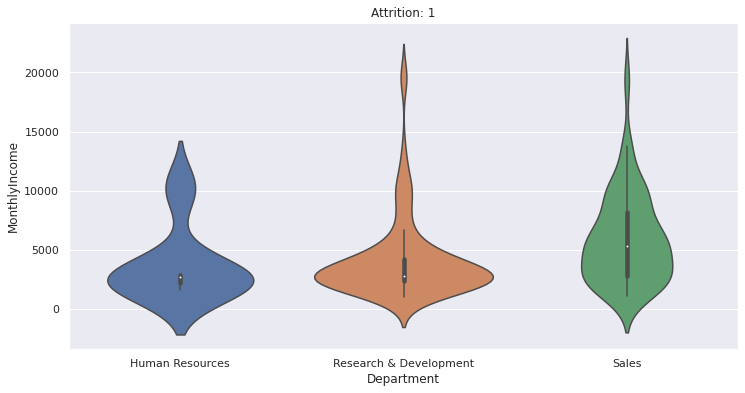

In [ ]:
# Comparison on MonthlyIncome for different Departments, classified on Attrition
mixedAnalysis('Department', 'MonthlyIncome', 'Attrition')

Comments:
- Monthly income leads to a large number of attrition in HR and Sales department
- But some employees with high income in research and developent department also leave the company in Sales and Development department. The reason might be heavy workloads.

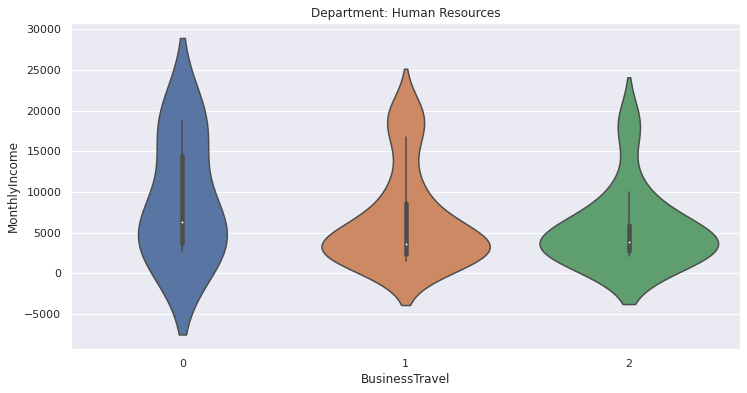

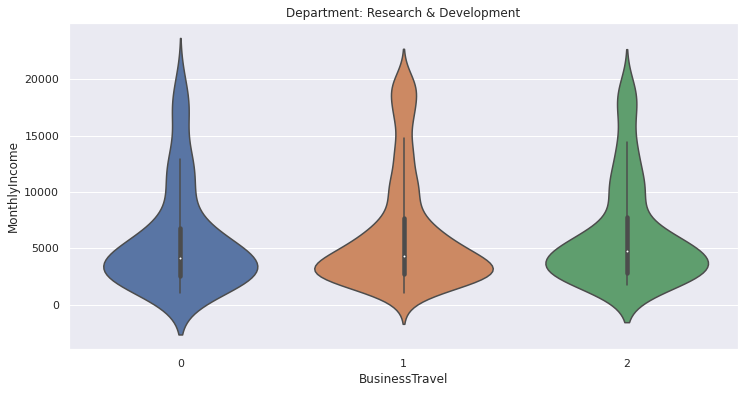

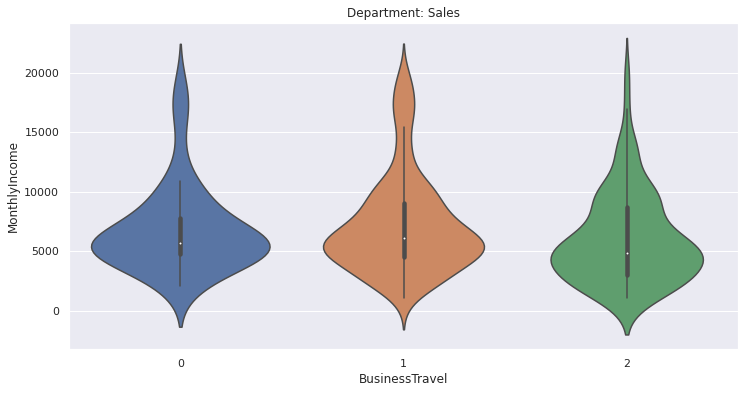

In [ ]:
# Comparison on MonthlyIncome for BusinessTravel frequency, classified on Departments
mixedAnalysis('BusinessTravel', 'MonthlyIncome', 'Department')

Comments:
- Monthly income ditributions in different business states have little differences
- But non-travel HR employees tends to have higher income compared to traveled ones, which means to remian HR talents, less travel and more online work are important factors. 

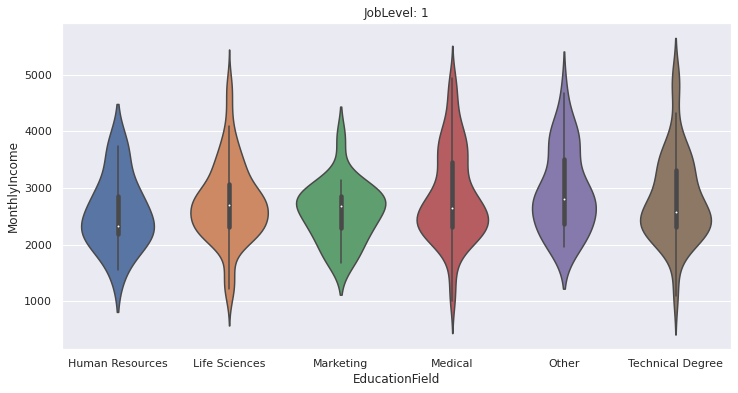

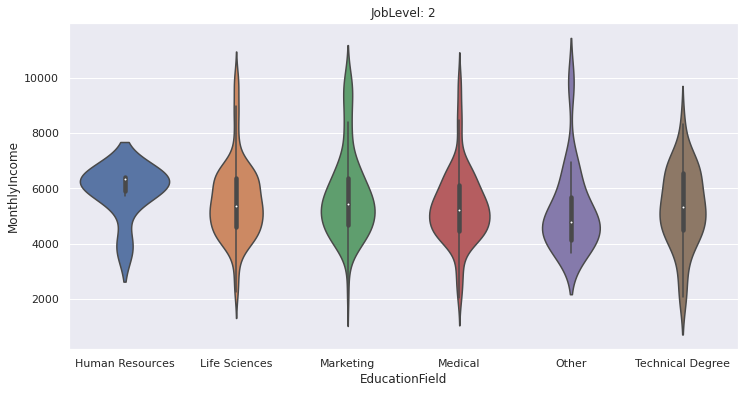

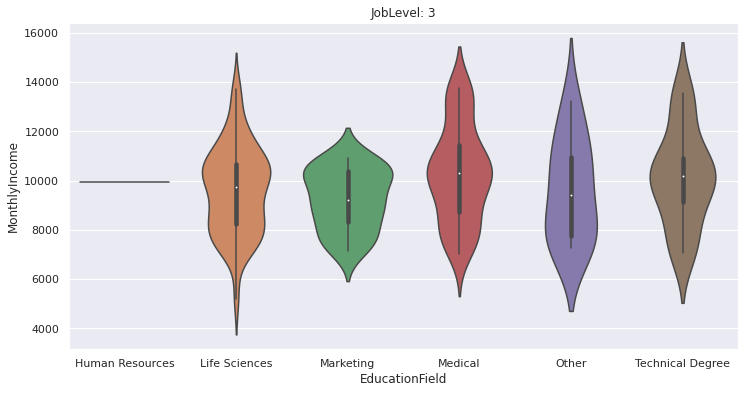

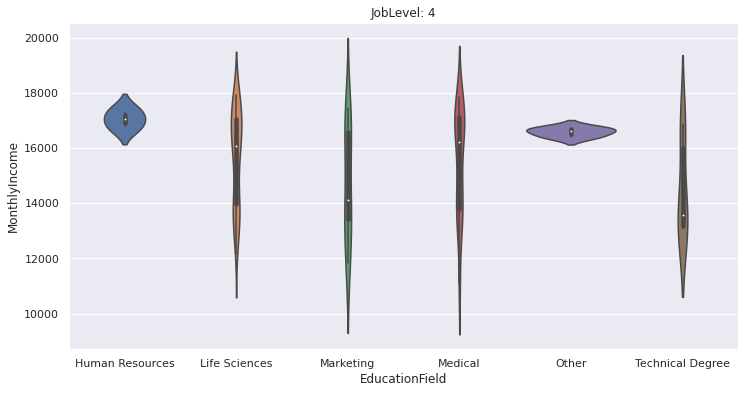

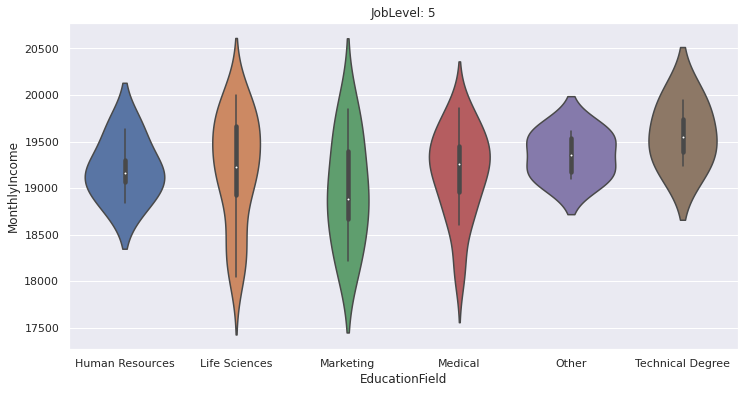

In [ ]:
# Comparison on MonthlyIncome for Education Field, classified on JobLevel
mixedAnalysis('EducationField', 'MonthlyIncome', 'JobLevel')

Comments:
- HR emplyees are all in highest and low job levels, little on medium range. Thus, if prefering a stable promotion, the employee might not consider HR where promotion might be hard.
- Technical employees have higher income in each level, especially in the highest job level
- Medical and life sciencea related fields have an average income level among all job levels.
- Marketing field is more suitable for a stable promotion.

## 7. Main Conclusions
- **Working conditions** are a  major factor in attrition (almost 3 times!)
- We estimated **the required ratio of income to  work experience ($479 per years of work experience)** needed to keep experienced employees in the company
- In the **higher age** bracket, **female** employees tend to stay in the same company compared to their male counterparts
- **Income, Age and distance** from work are related to attrition as expected from common knowledge
